### Table of Contents

* [1.0 Purpose](#1.0)
    * [1.1 Imports](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Inspect the data](#1.3)
* [2.1 Proportion of classes](#2.1)
    * [2.2 Dummy encoding](#2.2)
* [3.1 Split dataframe into features and target](#3.1)
    * [3.2 Preliminary modeling](#3.2)
    * [3.3 Preliminary model confusion matrix and classification report](#3.3)
* [4.0 Logistic regression model](#4.0)    
    * [4.1 Tuning hyperparameters using a pipeline and GridSearchCV](#4.1)
    * [4.2 Accuracy results](#4.2)
    * [4.3 F1 results](#4.3)
    * [4.4 Confusion matrix and classification report for the top model](#4.4)
* [5.0 Random Forest model](#5.0)



##### 1.0 Purpose<a id='1.0'></a>

In the previous notebook, we completed exploratory data analysis. The data was visualized in terms of correlations, both between features and targets, and between features and other features.

Now, in this notebook, we are in the preprocessing and training phase of this Capstone 2 project. We will be putting together different models for the training/testing process, then checking for accuracy.


##### 1.1 Imports<a id='1.1'></a>

In [173]:
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

##### 1.2 Load data<a id='1.2'></a>

In [174]:
path = r'C:\Users\Joseph Shire\Documents\Springboard Python Data Science\Python Scripts\springboard\Capstone2\Fetal health idea'
main_file = r'\ctg_final.csv'
df = pd.read_csv(path+main_file)
fc = r'\ctg_corr.csv'
fcorr = pd.read_csv(path+fc)
tc = r'\ctg_corr_NSP.csv'
tcorr = pd.read_csv(path+tc)

print('The main data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))

The main data have  2126  rows and  22  columns

column names: 

LB
AC
FM
UC
ASTV
MSTV
ALTV
MLTV
DL
DS
DP
Width
Min
Max
Nmax
Nzeros
Mode
Mean
Median
Variance
Tendency
NSP


Look at the correlation dataframes

In [175]:
tcorr.head()

,var_1,var_2,correlation,abs_corr,corr_level
0,DP,NSP_3.0,0.580253,0.580253,MID
1,ASTV,NSP_1.0,-0.493391,0.493391,LOW
2,ALTV,NSP_1.0,-0.489400,0.489400,LOW
3,NSP_3.0,Mode,-0.419051,0.419051,LOW
4,ALTV,NSP_2.0,0.418659,0.418659,LOW


In [176]:
fcorr.head()

,var_1,var_2,correlation,abs_corr,corr_level
0,Median,Mean,0.948251,0.948251,HIGH
1,Mode,Median,0.933399,0.933399,HIGH
2,Min,Width,-0.898519,0.898519,HIGH
3,Mode,Mean,0.893412,0.893412,HIGH
4,LB,Median,0.789246,0.789246,HIGH


##### 2.1 Proportion of classes<a id='2.1'></a>

When building classification models, it is essential to know right away the number of samples per class, proportionally to the total number of samples.

For our fetal health data, the diagnostic categories are: 1 = Normal = N, 2 = Suspect = S, 3 = Pathological = P.

In [177]:
class_counts_nsp = df['NSP'].value_counts()
print('Raw totals:\n')
print(class_counts_nsp)

Raw totals:

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64


In [178]:
class_p_nsp = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts_nsp], index=[1,2,3])
print('Percentages:\n')
print(class_p_nsp)

Percentages:

1    77.845720
2    13.875823
3     8.278457
dtype: float64


Visualize Proportionality

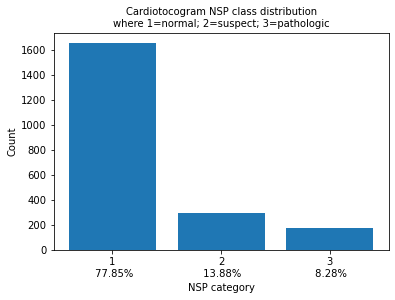

In [179]:
fig, ax = plt.subplots()
ax.bar(class_counts_nsp.index, class_counts_nsp)
ax.set_xticks([1,2,3])
ax.set_xticklabels(class_p_nsp.index.astype(str) + '\n' + ' ' +
                   class_p_nsp.round(2).astype(str) + '%')

ax.set_ylabel('Count')
ax.set_xlabel('NSP category')
ax.set_title('Cardiotocogram NSP class distribution\nwhere 1=normal; 2=suspect; 3=pathologic',
              fontsize = 10)
plt.show()

##### 2.2 Dummy encode only categorical feature<a id='2.2'></a>

The feature "Tendency" is a categorical variable, and will need dummies applied

In [180]:
df['Tendency'].value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: Tendency, dtype: int64

According to documentaiton, 'Tendency' is histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric

In [181]:
dfd = pd.get_dummies(df, columns = ['Tendency'])
dfd

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_-1.0,Tendency_0.0,Tendency_1.0
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,2.0,0.0,120.0,137.0,121.0,73.0,2.0,0,0,1
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,1.0,0,1,0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,1.0,0,1,0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0,0,1
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,4.0,0.0,153.0,150.0,152.0,2.0,2.0,0,1,0
2122,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,6.0,0.0,152.0,148.0,151.0,3.0,2.0,0,0,1
2123,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,5.0,0.0,153.0,148.0,152.0,4.0,2.0,0,0,1
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,6.0,0.0,152.0,147.0,151.0,4.0,2.0,0,0,1


##### 3.1 Split dataframe into features and target<a id='3.1'></a>

Setting our features as the X variable, and targets as the y variable for use in our modeling.

In [182]:
    dfd['NSP'] = df['NSP'].replace([1.0,2.0,3.0],['N','S','P'])

In [183]:
X = dfd.drop(columns = ['NSP'])

In [184]:
y = dfd['NSP']

In [185]:
print(X.head(),y.head())

      LB   AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL   DS  ...    Max  Nmax  \
0  120.0  0.0  0.0  0.0  73.0   0.5  43.0   2.4  0.0  0.0  ...  126.0   2.0   
1  132.0  4.0  0.0  4.0  17.0   2.1   0.0  10.4  2.0  0.0  ...  198.0   6.0   
2  133.0  2.0  0.0  5.0  16.0   2.1   0.0  13.4  2.0  0.0  ...  198.0   5.0   
3  134.0  2.0  0.0  6.0  16.0   2.4   0.0  23.0  2.0  0.0  ...  170.0  11.0   
4  132.0  4.0  0.0  5.0  16.0   2.4   0.0  19.9  0.0  0.0  ...  170.0   9.0   

   Nzeros   Mode   Mean  Median  Variance  Tendency_-1.0  Tendency_0.0  \
0     0.0  120.0  137.0   121.0      73.0              0             0   
1     1.0  141.0  136.0   140.0      12.0              0             1   
2     1.0  141.0  135.0   138.0      13.0              0             1   
3     0.0  137.0  134.0   137.0      13.0              0             0   
4     0.0  137.0  136.0   138.0      11.0              0             0   

   Tendency_1.0  
0             1  
1             0  
2             0  
3       

##### 3.2 Preliminary modeling<a id='3.2'></a>

Start by training a single model on a single set of parameters, to see what non-tuned results might look like

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 55, train_size = 0.80, stratify = y)

Using Logistic Regression, with the solver 'liblinear', maximum iterations set to 500, and regularization (C) at 1000

In [187]:
lr = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

We fit the training data to the model

In [188]:
lr.fit(X_train, y_train)

LogisticRegression(C=1000, max_iter=500, solver='liblinear')

Then assess accuracy scores for training and testing data

In [189]:
print(f'Accuracy on training data: {accuracy_score(lr.predict(X_train), y_train):.2f}')

Accuracy on training data: 0.91


In [190]:
print(f'Accuracy on test data: {accuracy_score(lr.predict(X_test), y_test):.2f}')

Accuracy on test data: 0.90


##### 3.3 Preliminary model confusion matrix and classification report<a id='3.3'></a>

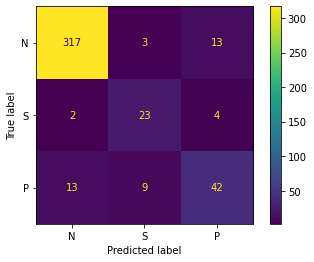

In [191]:
cm = confusion_matrix(lr.predict(X_test), y_test, labels = lr.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

Accuracy scores can be misleading, so a classification report is created for both training and testing data

In [192]:
print("Classification Report for Training Data")
print(classification_report(y_train, lr.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.94      0.96      0.95      1323
           P       0.88      0.80      0.84       141
           S       0.71      0.66      0.68       236

    accuracy                           0.91      1700
   macro avg       0.84      0.81      0.83      1700
weighted avg       0.91      0.91      0.91      1700



In [193]:
print("Classification Report for Test Data")
print(classification_report(y_test, lr.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.95      0.95      0.95       332
           P       0.79      0.66      0.72        35
           S       0.66      0.71      0.68        59

    accuracy                           0.90       426
   macro avg       0.80      0.77      0.79       426
weighted avg       0.90      0.90      0.90       426



The model performs well, and even does better for the test set than the training set across the board (better precision, recall, and F1 scores for all 3 classes)

##### 4.0 Logistic regression model<a id='4.0'></a>

Now we can commense hyperparameter tuning to get a better feel for what parameters could give us the best predictive power

In [194]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either es

##### 4.1 Tuning hyperparameters using a pipeline and GridSearchCV<a id='4.1'></a>

Initially, we will look at a Logistic Regression model.
The first step is to crete a pipeline. Within this step, we scale our data, since there are vastly differing scales among our features.
Next, we include multiple levels of regularization (parameter 'C'), and multiple solvers.
Finally, we use GridSearchCV to check accuracy scores across all combinations of the parameter choices.

In [195]:
steps = [("scaler",StandardScaler()),("logreg",LogisticRegression(max_iter = 8000))]
parameters = [0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100]

pipe = Pipeline(steps)
params = {"logreg__solver":['newton-cg','liblinear','sag','lbfgs','saga'],"logreg__C":parameters}

grid = GridSearchCV(pipe, param_grid=params, scoring="accuracy")
grid.fit(X_train, y_train)
results2 = pd.DataFrame(grid.cv_results_)


##### 4.2 Accuracy results<a id='4.2'></a>

The results are stored within a pandas dataframe for easy viewing, sorted by the mean test score.
The best result is also printed individually.

In [196]:
best_results = [grid.best_estimator_, grid.best_params_, grid.best_score_]
focus_results = results2.iloc[:, [4,5,12]].sort_values(['mean_test_score','param_logreg__C'], ascending=[False,True]).reset_index(drop=True)
print(focus_results.head(10))
print(best_results)

  param_logreg__C param_logreg__solver  mean_test_score
0              50                  sag         0.898824
1              50                 saga         0.898824
2             100                 saga         0.898824
3              50            newton-cg         0.898235
4              50                lbfgs         0.898235
5             100            newton-cg         0.898235
6             100                  sag         0.898235
7             100                lbfgs         0.898235
8               5                 saga         0.897647
9              10            newton-cg         0.897647
[Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=50, max_iter=8000, solver='sag'))]), {'logreg__C': 50, 'logreg__solver': 'sag'}, 0.8988235294117647]


Using scaled training data in our gridsearched pipeline (with multiple regression solvers and multiple levels of C) results in a 'best performance' by the 'sag' solver at a C of 50, with an accuracy score of 0.8988.

##### 4.3 F1 results<a id='4.3'></a>

We can repeat this step using a different scoring metric. Taking the F1 score, which is the harmonic mean of Precision and Recall, we achieve a better measure of the incorrectly classified cases than 'accuracy'.

F1 scoring is better for cases of imbalanced classes, as well as when correctly identifying false positives/negatives is more important than identifying true positives/negatives.

Our situation with identifying fetal heart abnormalities falls into both mentioned use-cases for utilizing 'F1' over 'accuracy' for scoring.

In [197]:
stepsF1 = [("scaler",StandardScaler()),("logreg",LogisticRegression(max_iter = 8000))]
parametersF1 = [0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100]

pipeF1 = Pipeline(stepsF1)
paramsF1 = {"logreg__solver":['newton-cg','liblinear','sag','lbfgs','saga'],"logreg__C":parametersF1}

gridF1 = GridSearchCV(pipeF1, param_grid=paramsF1, scoring='f1_macro')
gridF1.fit(X_train, y_train)
resultsF1 = pd.DataFrame(gridF1.cv_results_)

In [198]:
best_resultsF1 = [gridF1.best_estimator_, gridF1.best_params_, gridF1.best_score_]
focus_resultsF1 = resultsF1.iloc[:, [4,5,12]].sort_values(['mean_test_score','param_logreg__C'], ascending=[False,True]).reset_index(drop=True)
print(focus_resultsF1.head(10))
print(best_resultsF1)

  param_logreg__C param_logreg__solver  mean_test_score
0              50                  sag         0.805882
1              50                 saga         0.805882
2             100                 saga         0.805882
3               5                 saga         0.804904
4              50            newton-cg         0.803984
5              50                lbfgs         0.803984
6             100            newton-cg         0.803984
7             100                  sag         0.803984
8             100                lbfgs         0.803984
9              10            newton-cg         0.803702
[Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=50, max_iter=8000, solver='sag'))]), {'logreg__C': 50, 'logreg__solver': 'sag'}, 0.8058822074974563]


Results from the GridSearchCV set to F1 as the scoring mechanism paint a similar picture. 'sag' solver at C = 50 is the top performer.

##### 4.4 Confusion matrix and classification report for the top model<a id='4.4'></a>

Training set:

In [204]:
lrs = LogisticRegression(solver = 'sag', max_iter = 8000, C = 50)
lrs.fit(X_train, y_train)
print("Classification Report for Training Data")
print(classification_report(y_train, lrs.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.93      0.96      0.94      1323
           P       0.88      0.84      0.86       141
           S       0.67      0.60      0.63       236

    accuracy                           0.90      1700
   macro avg       0.83      0.80      0.81      1700
weighted avg       0.89      0.90      0.89      1700



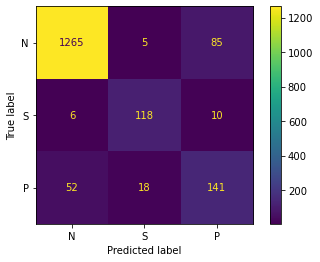

In [205]:
cm = confusion_matrix(lrs.predict(X_train), y_train, labels = lrs.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

Test set:

In [206]:
print("Classification Report for Testing Data")
print(classification_report(y_test, lrs.predict(X_test)))

Classification Report for Testing Data
              precision    recall  f1-score   support

           N       0.95      0.94      0.94       332
           P       0.71      0.71      0.71        35
           S       0.61      0.63      0.62        59

    accuracy                           0.88       426
   macro avg       0.76      0.76      0.76       426
weighted avg       0.88      0.88      0.88       426



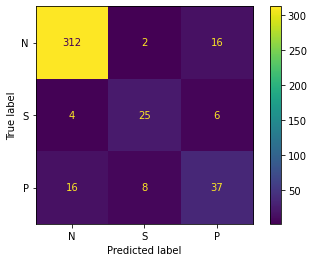

In [207]:
cm = confusion_matrix(lrs.predict(X_test), y_test, labels = lrs.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

The model does mediocre on the test set. Out of curiosity, we will try 'liblinear' as a solver.

Liblinear solver

In [240]:
lrl = LogisticRegression(solver = 'liblinear', max_iter = 8000, C = 10)
lrl.fit(X_train, y_train)
print("Classification Report for Training Data")
print(classification_report(y_train, lrl.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.94      0.96      0.95      1323
           P       0.88      0.80      0.84       141
           S       0.70      0.64      0.67       236

    accuracy                           0.90      1700
   macro avg       0.84      0.80      0.82      1700
weighted avg       0.90      0.90      0.90      1700



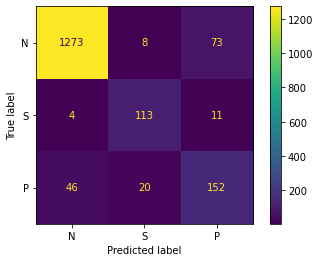

In [241]:
cm = confusion_matrix(lrl.predict(X_train), y_train, labels = lrl.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

In [244]:
print("Classification Report for Testing Data")
print(classification_report(y_test, lrl.predict(X_test)))

Classification Report for Testing Data
              precision    recall  f1-score   support

           N       0.95      0.96      0.95       332
           P       0.82      0.66      0.73        35
           S       0.67      0.71      0.69        59

    accuracy                           0.90       426
   macro avg       0.81      0.78      0.79       426
weighted avg       0.90      0.90      0.90       426



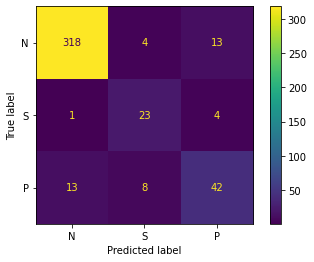

In [245]:
cm = confusion_matrix(lrl.predict(X_test), y_test, labels = lrl.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

##### 5.0 Random Forest model<a id='5.0'></a>

Now to try a different regressor: Random Forest

##### 5.1 Tuning hyperparameters using a pipeline and GridSearchCV<a id='5.1'></a>

In [227]:
stepsRF = [('rf', RandomForestClassifier(random_state=55))]

pipeRF = Pipeline(stepsRF)
paramsRF = {'rf__n_estimators': [10, 20, 50, 80, 100, 200, 500, 1000],
           'rf__max_depth':[2,3]}

gridRF = GridSearchCV(pipeRF, param_grid=paramsRF, n_jobs=-1)
gridRF.fit(X_train, y_train)
resultsRF = pd.DataFrame(gridRF.cv_results_)


In [231]:
best_resultsRF = [gridRF.best_estimator_, gridRF.best_params_, gridRF.best_score_]
print(best_resultsRF)

[Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, random_state=55))]), {'rf__max_depth': 3, 'rf__n_estimators': 100}, 0.8988235294117647]


In [232]:
forest = RandomForestClassifier(random_state=55,n_estimators = 100, max_depth=3)
forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, random_state=55)

In [233]:
y_pred_test = forest.predict(X_test)


In [239]:
print("Classification Report for RF Testing Data")
print(classification_report(y_test, forest.predict(X_test)))

Classification Report for RF Testing Data
              precision    recall  f1-score   support

           N       0.90      0.99      0.95       332
           P       0.95      0.54      0.69        35
           S       0.75      0.51      0.61        59

    accuracy                           0.89       426
   macro avg       0.87      0.68      0.75       426
weighted avg       0.88      0.89      0.88       426



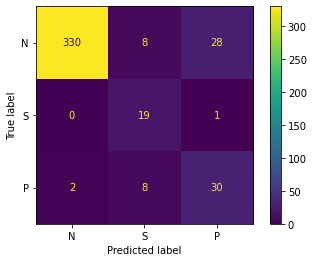

In [238]:
cm = confusion_matrix(forest.predict(X_test), y_test, labels = forest.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['N', 'S','P'])
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

Visualizing a couple of random trees of the forest

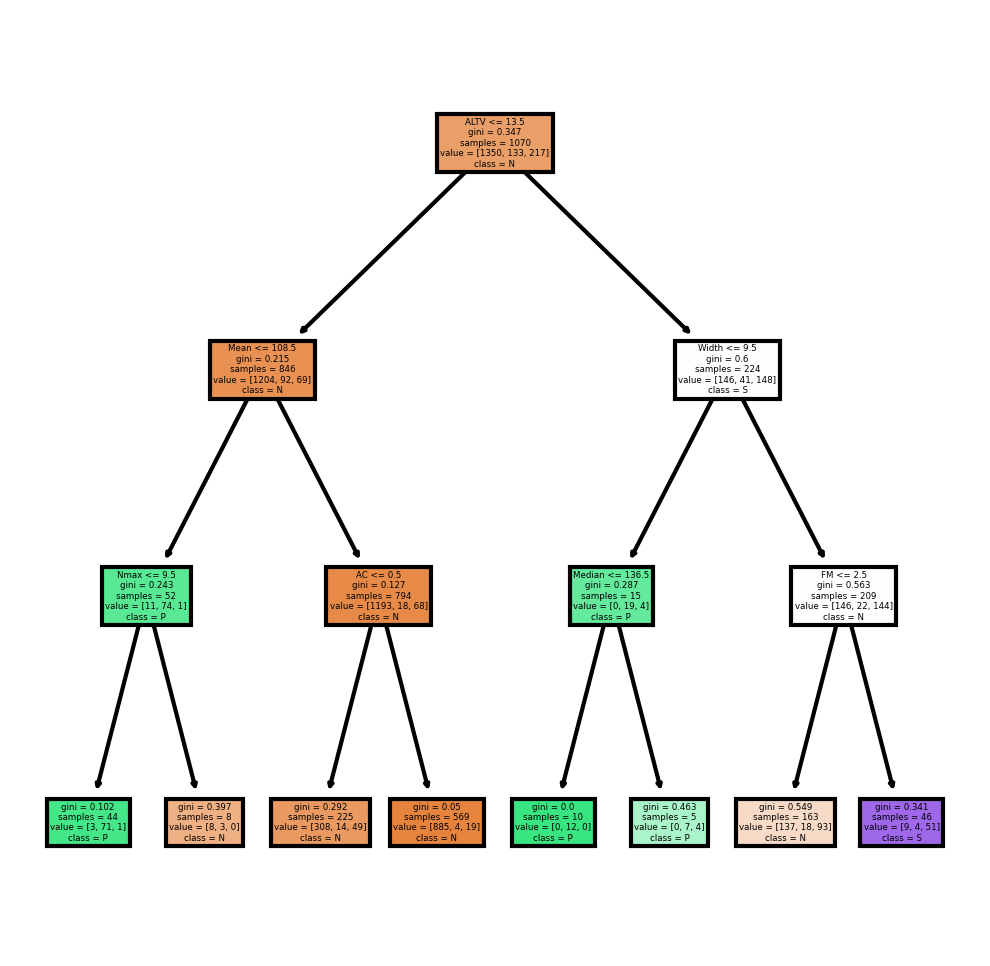

In [235]:
fn=X.columns

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(forest.estimators_[0],
               feature_names = fn, 
               class_names= forest.classes_,
               filled = True);
fig.savefig('imagename1.png')

Looking at a different tree of the same forest

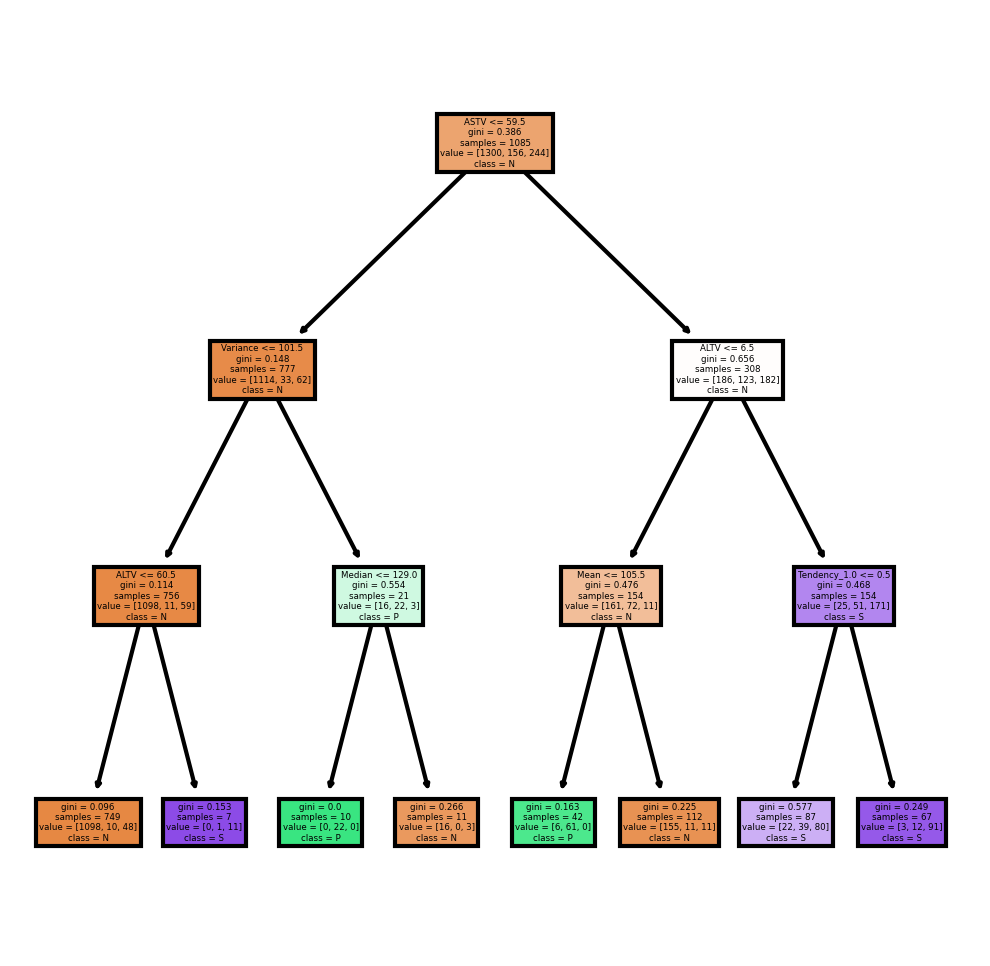

In [237]:
fn=X.columns

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(forest.estimators_[7],
               feature_names = fn, 
               class_names= forest.classes_,
               filled = True);
fig.savefig('imagename2.png')

Compare to decision tree model:

In [229]:
clf = DecisionTreeClassifier(max_depth = 2, random_state = 55)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=2, random_state=55)

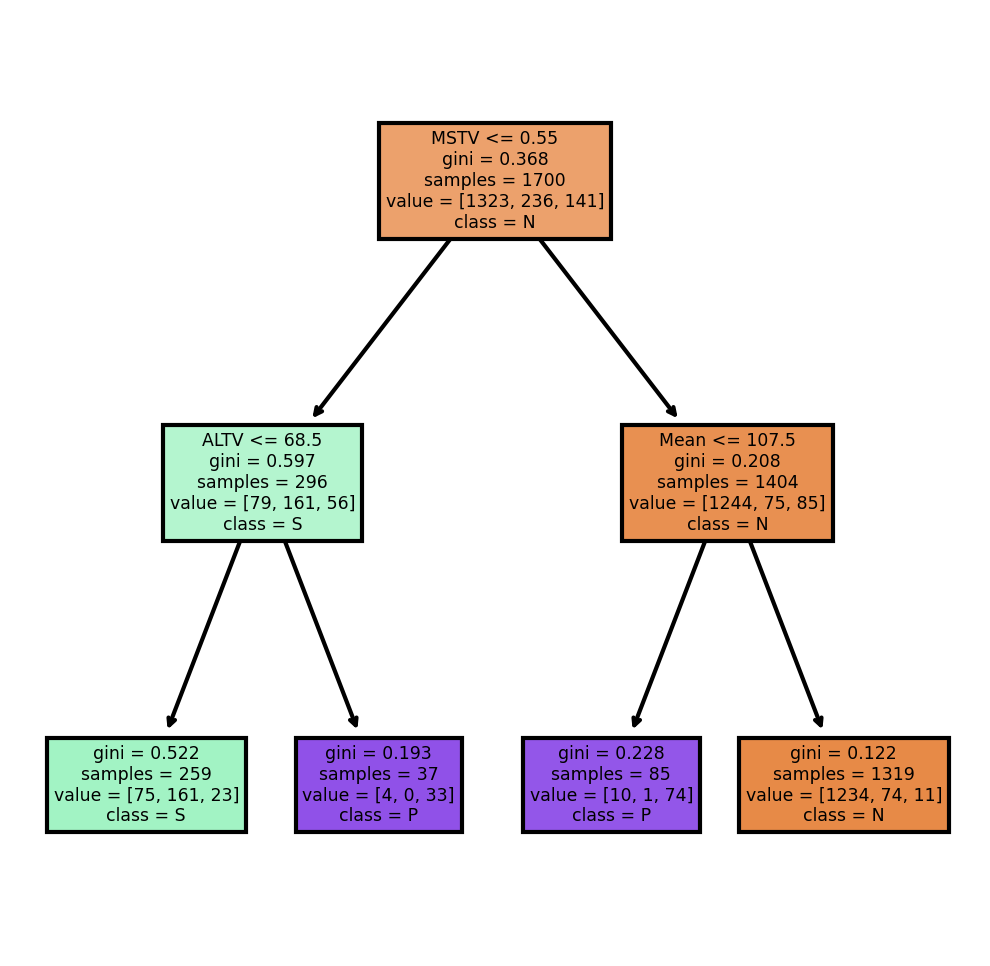

In [74]:
fn=X.columns

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names= forest.classes_,
               filled = True);
fig.savefig('imagename1.png')